In [3]:
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modelos a comparar
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Métricas de evaluación
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, f1_score

# Para mostrar la tabla final
from IPython.display import display

In [ ]:
models_to_test = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVC': SVC(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

In [5]:
def evaluate_models(X, y, models, dataset_name):
    """
    Entrena y evalúa una lista de modelos en un dataset.
    Devuelve una lista de diccionarios con los resultados de cada modelo.
    """
    print(f"--- Evaluando Dataset: {dataset_name} ---")
    
    results_list = []
    
    # Preprocesamiento
    categorical_features = X.select_dtypes(include=['category', 'object']).columns
    numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ],
        remainder='passthrough'
    )
    
    # División de datos
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    # Bucle para probar cada modelo
    for model_name, model in models.items():
        print(f"\nProbando modelo: {model_name}...")
        
        # Crear y entrenar el pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        # Calcular y mostrar métricas
        print("Matriz de Confusión:")
        print(confusion_matrix(y_test, y_pred))
        
        bal_acc = balanced_accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
        
        print(f"Balanced Accuracy: {bal_acc:.3f}")
        print(f"F1-Score (clase 'mala'): {f1:.3f}")
        
        # Guardar resultados
        results_list.append({
            'dataset': dataset_name,
            'model': model_name,
            'balanced_accuracy': bal_acc,
            'f1_score_bad_class': f1
        })
        
    return results_list

In [ ]:
# Primero, descarga el fichero 'cs-training.csv' de Kaggle y guárdalo en la misma carpeta que este notebook.

datasets_to_test = {
    'German Credit': {'source': 'openml', 'id': 31},
    'Taiwan Credit Default': {'source': 'openml', 'id': 42477},
    'Credit Card Fraud': {'source': 'openml', 'id': 1597},
    'Give Me Some Credit': {'source': 'csv', 'path': 'cs-training.csv', 'target_col': 'SeriousDlqin2yrs'}
}

all_results = []

for name, info in datasets_to_test.items():
    try:
        print(f"--- Cargando y procesando dataset: {name} ---")
        
        if info['source'] == 'openml':
            # Cargar desde OpenML
            data = fetch_openml(data_id=info['id'], as_frame=True, parser='auto')
            X = data.data
            y_raw = data.target if 'target' in data else data['class']
            # Aseguramos que 'y' sea binaria (0s y 1s)
            y = pd.Series(pd.factorize(y_raw)[0], index=y_raw.index)

        elif info['source'] == 'csv':
            # Cargar desde archivo CSV local
            df_csv = pd.read_csv(info['path'])
            
            # Limpieza específica para 'Give Me Some Credit'
            if 'Unnamed: 0' in df_csv.columns:
                df_csv = df_csv.drop('Unnamed: 0', axis=1)
            
            target_column = info['target_col']
            X = df_csv.drop(target_column, axis=1)
            y = df_csv[target_column] # La 'y' ya es binaria en este dataset
            
            # Estrategia simple para manejar valores nulos (NaN)
            X = X.fillna(X.mean())

        # Una vez cargados los datos (X, y), llamamos a la función de evaluación
        results = evaluate_models(X, y, models_to_test, name)
        all_results.extend(results)
        print("\n" + "="*60 + "\n")

    except FileNotFoundError:
        print(f"🚨 ERROR: No se encontró el archivo '{info['path']}' para el dataset {name}.")
        print("Asegúrate de que está en la misma carpeta que el notebook.")
    except Exception as e:
        print(f"🚨 No se pudo procesar el dataset {name}. Error: {e}")
        print("\n" + "="*60 + "\n")

--- Cargando y procesando dataset: German Credit ---
--- Evaluando Dataset: German Credit ---

Probando modelo: Logistic Regression...
Matriz de Confusión:
[[187  23]
 [ 42  48]]
Balanced Accuracy: 0.712
F1-Score (clase 'mala'): 0.596

Probando modelo: Random Forest...
Matriz de Confusión:
[[196  14]
 [ 55  35]]
Balanced Accuracy: 0.661
F1-Score (clase 'mala'): 0.504

Probando modelo: SVC...
Matriz de Confusión:
[[196  14]
 [ 53  37]]
Balanced Accuracy: 0.672
F1-Score (clase 'mala'): 0.525

Probando modelo: Decision Tree...
Matriz de Confusión:
[[158  52]
 [ 51  39]]
Balanced Accuracy: 0.593
F1-Score (clase 'mala'): 0.431


--- Cargando y procesando dataset: Taiwan Credit Default ---
--- Evaluando Dataset: Taiwan Credit Default ---

Probando modelo: Logistic Regression...
Matriz de Confusión:
[[ 482 1509]
 [ 183 6826]]
Balanced Accuracy: 0.608
F1-Score (clase 'mala'): 0.890

Probando modelo: Random Forest...
Matriz de Confusión:
[[ 771 1220]
 [ 399 6610]]
Balanced Accuracy: 0.665
F1-Sc

In [7]:
final_results_df = pd.DataFrame(all_results)

print("✅ --- TABLA COMPARATIVA FINAL DE MODELOS --- ✅")
display(final_results_df.sort_values(by=['dataset', 'balanced_accuracy'], ascending=[True, False]))

✅ --- TABLA COMPARATIVA FINAL DE MODELOS --- ✅


,dataset,model,balanced_accuracy,f1_score_bad_class
9,Credit Card Fraud,Random Forest,0.881727,0.849624
11,Credit Card Fraud,Decision Tree,0.868091,0.770318
8,Credit Card Fraud,Logistic Regression,0.807345,0.716535
10,Credit Card Fraud,SVC,0.800658,0.741667
0,German Credit,Logistic Regression,0.711905,0.596273
2,German Credit,SVC,0.672222,0.524823
1,German Credit,Random Forest,0.661111,0.503597
3,German Credit,Decision Tree,0.592857,0.430939
15,Give Me Some Credit,Decision Tree,0.615006,0.276404
13,Give Me Some Credit,Random Forest,0.587051,0.277500


In [8]:
# Celda 6: Calcular y mostrar el rendimiento medio de cada modelo
print("📊 --- RENDIMIENTO MEDIO POR MODELO (TODOS LOS DATASETS) --- 📊")

# Agrupamos por 'model' y calculamos la media de las métricas
average_performance = final_results_df.groupby('model')[['balanced_accuracy', 'f1_score_bad_class']].mean()

# Ordenamos por la métrica que consideremos más importante para ver el ranking
average_performance_sorted = average_performance.sort_values(by='balanced_accuracy', ascending=False)

display(average_performance_sorted)

📊 --- RENDIMIENTO MEDIO POR MODELO (TODOS LOS DATASETS) --- 📊


,balanced_accuracy,f1_score_bad_class
model,,
Random Forest,0.698762,0.630404
Decision Tree,0.673914,0.575915
Logistic Regression,0.661724,0.570002
SVC,0.661295,0.562123


ANALISIS SENSIBLE A COSTES

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report # Asegurarse de que classification_report está importado

def evaluate_cost_sensitive_models(X, y, models, dataset_name):
    """
    Versión de la función de evaluación que entrena los modelos
    con sensibilidad al coste y MUESTRA los resultados detallados.
    """
    print(f"--- Evaluando Dataset (Sensible a Costes): {dataset_name} ---")
    
    results_list = []
    
    # Mismo preprocesamiento y división que antes
    categorical_features = X.select_dtypes(include=['category', 'object']).columns
    numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ],
        remainder='passthrough'
    )
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    for model_name, model in models.items():
        print(f"\nProbando modelo: {model_name} (Sensible al Coste)...")
        
        # Re-inicializamos el modelo con el parámetro class_weight='balanced'
        if model_name == 'Logistic Regression':
            model_cs = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
        elif model_name == 'Random Forest':
            model_cs = RandomForestClassifier(random_state=42, class_weight='balanced')
        elif model_name == 'SVC':
            model_cs = SVC(random_state=42, class_weight='balanced')
        elif model_name == 'Decision Tree':
            model_cs = DecisionTreeClassifier(random_state=42, class_weight='balanced')

        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model_cs)
        ])
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        # --- CÓDIGO AÑADIDO PARA MOSTRAR DETALLES ---
        print("Matriz de Confusión:")
        print(confusion_matrix(y_test, y_pred))
        
        bal_acc = balanced_accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
        
        print(f"Balanced Accuracy: {bal_acc:.3f}")
        print(f"F1-Score (clase 'mala'): {f1:.3f}")
        print("Reporte de Clasificación:")
        # Usamos try-except por si alguna predicción no tiene ambas clases
        try:
            target_names = [f'Clase {i}' for i in sorted(y.unique())]
            print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))
        except:
            print(classification_report(y_test, y_pred, zero_division=0))

        # --- FIN DEL CÓDIGO AÑADIDO ---

        results_list.append({
            'dataset': dataset_name,
            'model': model_name,
            'balanced_accuracy': bal_acc,
            'f1_score_bad_class': f1
        })
        
    return results_list

In [ ]:
# Ejecutamos el mismo bucle que en la celda 4, pero llamando a la nueva función
all_results_cs = []

for name, info in datasets_to_test.items():
    try:
        if info['source'] == 'openml':
            data = fetch_openml(data_id=info['id'], as_frame=True, parser='auto')
            X = data.data
            y_raw = data.target if 'target' in data else data['class']
            y = pd.Series(pd.factorize(y_raw)[0], index=y_raw.index)

        elif info['source'] == 'csv':
            df_csv = pd.read_csv(info['path'])
            if 'Unnamed: 0' in df_csv.columns:
                df_csv = df_csv.drop('Unnamed: 0', axis=1)
            target_column = info['target_col']
            X = df_csv.drop(target_column, axis=1)
            y = df_csv[target_column]
            X = X.fillna(X.mean())

        # Llamamos a la NUEVA función de evaluación sensible al coste
        results_cs = evaluate_cost_sensitive_models(X, y, models_to_test, name)
        all_results_cs.extend(results_cs)
        print("\n" + "="*60 + "\n")

    except Exception as e:
        print(f"🚨 No se pudo procesar el dataset {name}. Error: {e}")

# Creamos un DataFrame con los nuevos resultados
final_results_cs_df = pd.DataFrame(all_results_cs)

--- Evaluando Dataset (Sensible a Costes): German Credit ---

Probando modelo: Logistic Regression (Sensible al Coste)...
Matriz de Confusión:
[[150  60]
 [ 21  69]]
Balanced Accuracy: 0.740
F1-Score (clase 'mala'): 0.630
Reporte de Clasificación:
              precision    recall  f1-score   support

     Clase 0       0.88      0.71      0.79       210
     Clase 1       0.53      0.77      0.63        90

    accuracy                           0.73       300
   macro avg       0.71      0.74      0.71       300
weighted avg       0.77      0.73      0.74       300


Probando modelo: Random Forest (Sensible al Coste)...
Matriz de Confusión:
[[194  16]
 [ 61  29]]
Balanced Accuracy: 0.623
F1-Score (clase 'mala'): 0.430
Reporte de Clasificación:
              precision    recall  f1-score   support

     Clase 0       0.76      0.92      0.83       210
     Clase 1       0.64      0.32      0.43        90

    accuracy                           0.74       300
   macro avg       0.70   

In [ ]:
# Añadimos una columna 'Tipo' para diferenciar los resultados
final_results_df['Tipo'] = 'Convencional'
final_results_cs_df['Tipo'] = 'Sensible al Coste'

# Unimos las dos tablas de resultados
comparison_df = pd.concat([final_results_df, final_results_cs_df])

# Mostramos la tabla final, ordenada para facilitar la comparación
print("📊 --- TABLA COMPARATIVA FINAL: EVOLUCIÓN CON SENSIBILIDAD A COSTES --- 📊")

display(comparison_df.sort_values(by=['dataset', 'model', 'Tipo']))

📊 --- TABLA COMPARATIVA FINAL: EVOLUCIÓN CON SENSIBILIDAD A COSTES --- 📊


,dataset,model,balanced_accuracy,f1_score_bad_class,Tipo
11,Credit Card Fraud,Decision Tree,0.868091,0.770318,Convencional
11,Credit Card Fraud,Decision Tree,0.824137,0.695652,Sensible al Coste
8,Credit Card Fraud,Logistic Regression,0.807345,0.716535,Convencional
8,Credit Card Fraud,Logistic Regression,0.924743,0.119169,Sensible al Coste
9,Credit Card Fraud,Random Forest,0.881727,0.849624,Convencional
9,Credit Card Fraud,Random Forest,0.851334,0.815686,Sensible al Coste
10,Credit Card Fraud,SVC,0.800658,0.741667,Convencional
10,Credit Card Fraud,SVC,0.833012,0.400810,Sensible al Coste
3,German Credit,Decision Tree,0.592857,0.430939,Convencional
3,German Credit,Decision Tree,0.591270,0.432432,Sensible al Coste


📊 --- INICIANDO ANÁLISIS AVANZADO Y COMPARATIVA P-R --- 📊

Cargando dataset 'Credit Card Fraud'...
Dataset cargado.
Datos divididos en entrenamiento y prueba.
Entrenando Modelo Convencional (lr_conv)...
Creando pesos por muestra (sample_weight)...
Entrenando Modelo Avanzado (lr_advanced_cs) con sample_weight...

--- Resultados del Modelo Avanzado (Umbral 0.5) ---
Matriz de Confusión:
[[84953   342]
 [   25   123]]

Reporte de Clasificación:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     85295
      Fraude       0.26      0.83      0.40       148

    accuracy                           1.00     85443
   macro avg       0.63      0.91      0.70     85443
weighted avg       1.00      1.00      1.00     85443


Generando Curva Precisión-Recall comparativa...


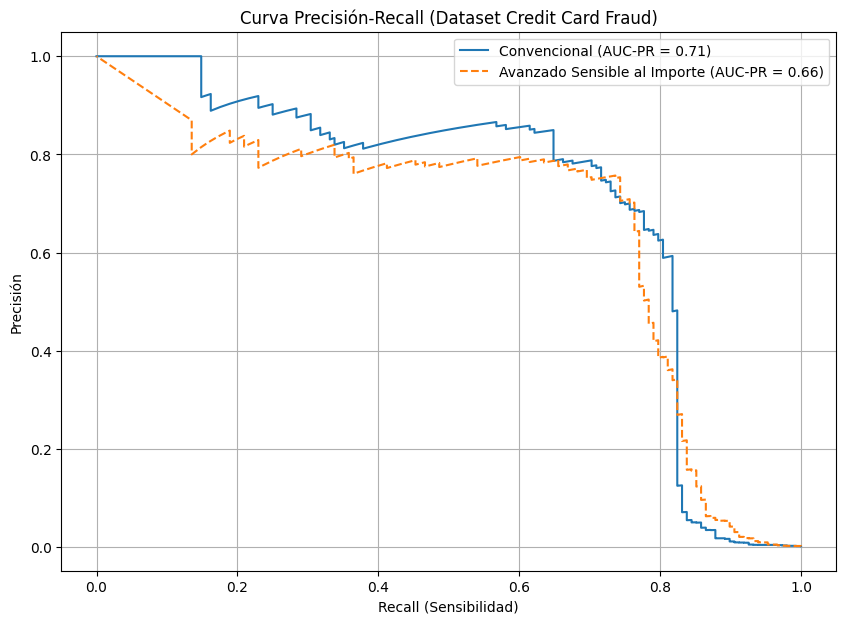

In [16]:
# --- CELDA 10 ACTUALIZADA: ANÁLISIS AVANZADO Y CURVA P-R ---

import numpy as np
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

print("📊 --- INICIANDO ANÁLISIS AVANZADO Y COMPARATIVA P-R --- 📊")

# 1. Cargar el dataset 'Credit Card Fraud'
print("\nCargando dataset 'Credit Card Fraud'...")
try:
    data_fraud = fetch_openml(data_id=1597, as_frame=True, parser='auto')
    X_fraud = data_fraud.data
    y_fraud = pd.Series(pd.factorize(data_fraud.target)[0], index=data_fraud.target.index)
    print("Dataset cargado.")

    # 2. Preparación de los datos
    amount_original = X_fraud['Amount'].copy()
    scaler = StandardScaler()
    X_fraud['scaled_amount'] = scaler.fit_transform(X_fraud[['Amount']])
    X_fraud_proc = X_fraud.drop('Amount', axis=1)

    # 3. División de datos (la misma para ambos modelos)
    X_train, X_test, y_train, y_test = train_test_split(
        X_fraud_proc, y_fraud, test_size=0.3, random_state=42, stratify=y_fraud
    )
    print("Datos divididos en entrenamiento y prueba.")

    # --- 4. ENTRENAMIENTO MODELO CONVENCIONAL ---
    print("Entrenando Modelo Convencional (lr_conv)...")
    lr_conv = LogisticRegression(random_state=42, max_iter=1000)
    lr_conv.fit(X_train, y_train)
    y_probs_conv = lr_conv.predict_proba(X_test)[:, 1] # Guardamos probabilidades

    # --- 5. ENTRENAMIENTO MODELO AVANZADO ---
    print("Creando pesos por muestra (sample_weight)...")
    amount_train = amount_original.loc[y_train.index]
    sample_weights = pd.Series(
        np.where(y_train == 1, amount_train + 1, 1),
        index=y_train.index
    )
    
    print("Entrenando Modelo Avanzado (lr_advanced_cs) con sample_weight...")
    lr_advanced_cs = LogisticRegression(random_state=42, max_iter=1000)
    lr_advanced_cs.fit(X_train, y_train, sample_weight=sample_weights)
    y_probs_advanced = lr_advanced_cs.predict_proba(X_test)[:, 1] # Guardamos probabilidades
    
    # Evaluar el modelo avanzado (como tenías en los resultados anteriores)
    y_pred_advanced = lr_advanced_cs.predict(X_test)
    print("\n--- Resultados del Modelo Avanzado (Umbral 0.5) ---")
    print("Matriz de Confusión:")
    print(confusion_matrix(y_test, y_pred_advanced))
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred_advanced, target_names=['Normal', 'Fraude']))


    # --- 6. GRÁFICA COMPARATIVA P-R ---
    print("\nGenerando Curva Precisión-Recall comparativa...")
    precision_conv, recall_conv, _ = precision_recall_curve(y_test, y_probs_conv)
    precision_adv, recall_adv, _ = precision_recall_curve(y_test, y_probs_advanced)

    auc_pr_conv = auc(recall_conv, precision_conv)
    auc_pr_advanced = auc(recall_adv, precision_adv)

    plt.figure(figsize=(10, 7))
    plt.plot(recall_conv, precision_conv, label=f'Convencional (AUC-PR = {auc_pr_conv:.2f})')
    plt.plot(recall_adv, precision_adv, label=f'Avanzado Sensible al Importe (AUC-PR = {auc_pr_advanced:.2f})', linestyle='--')

    plt.title('Curva Precisión-Recall (Dataset Credit Card Fraud)')
    plt.xlabel('Recall (Sensibilidad)')
    plt.ylabel('Precisión')
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"🚨 Error durante el análisis avanzado: {e}")

📊 --- COMPARATIVA AVANZADA (sample_weight) CON MODELOS COMPLEJOS --- 📊

Probando modelo: Decision Tree
Entrenando Decision Tree (Convencional)...
Entrenando Decision Tree (Avanzado con sample_weight)...
Entrenamiento completado.

--- Resultados del Decision Tree Avanzado (Umbral 0.5) ---
Matriz de Confusión:
[[85256    39]
 [   42   106]]

Reporte de Clasificación:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     85295
      Fraude       0.73      0.72      0.72       148

    accuracy                           1.00     85443
   macro avg       0.87      0.86      0.86     85443
weighted avg       1.00      1.00      1.00     85443


Generando Curva P-R comparativa (Decision Tree)...


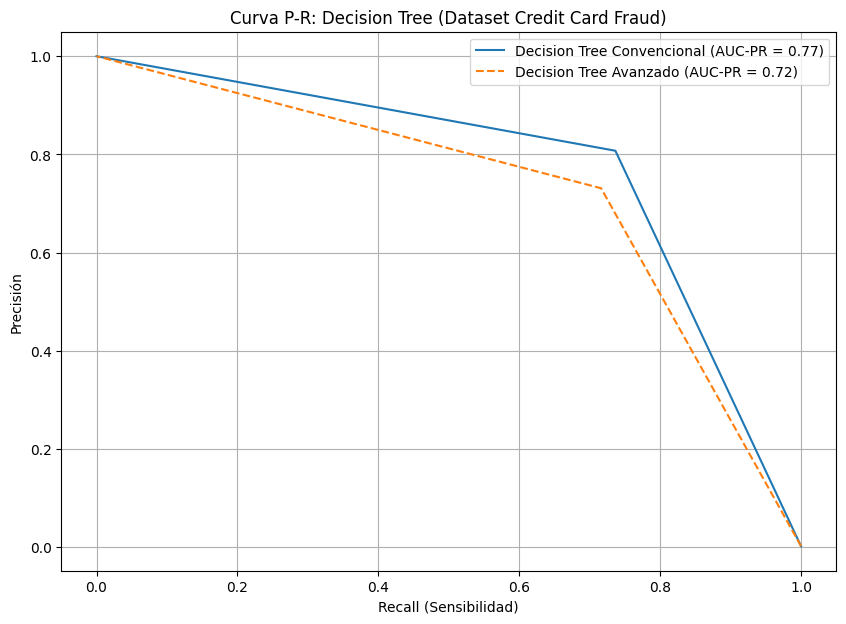


Probando modelo: SVC
Entrenando SVC (Convencional)...
Entrenando SVC (Avanzado con sample_weight)...
Entrenamiento completado.

--- Resultados del SVC Avanzado (Umbral 0.5) ---
Matriz de Confusión:
[[85280    15]
 [   50    98]]

Reporte de Clasificación:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     85295
      Fraude       0.87      0.66      0.75       148

    accuracy                           1.00     85443
   macro avg       0.93      0.83      0.88     85443
weighted avg       1.00      1.00      1.00     85443


Generando Curva P-R comparativa (SVC)...


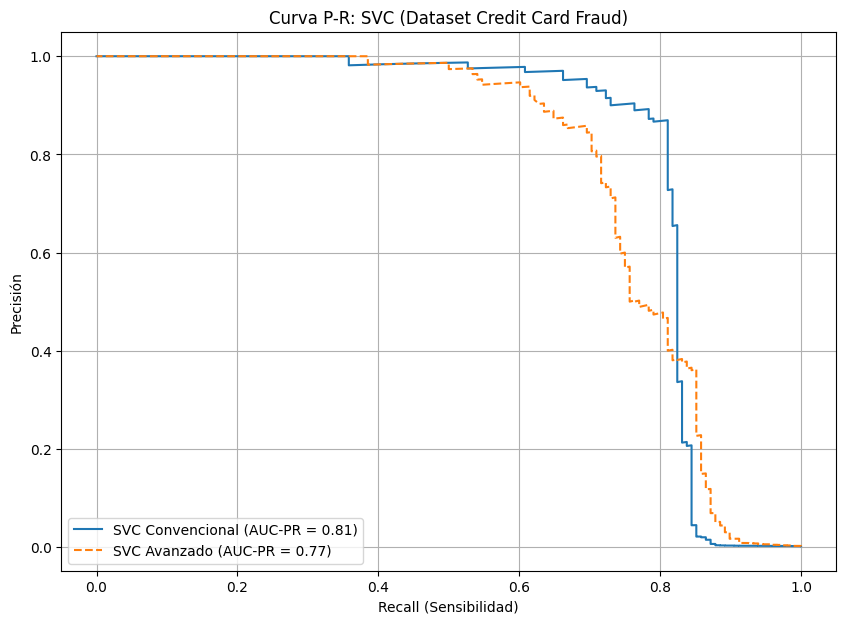


Probando modelo: Random Forest
Entrenando Random Forest (Convencional)...
Entrenando Random Forest (Avanzado con sample_weight)...
Entrenamiento completado.

--- Resultados del Random Forest Avanzado (Umbral 0.5) ---
Matriz de Confusión:
[[85291     4]
 [   41   107]]

Reporte de Clasificación:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     85295
      Fraude       0.96      0.72      0.83       148

    accuracy                           1.00     85443
   macro avg       0.98      0.86      0.91     85443
weighted avg       1.00      1.00      1.00     85443


Generando Curva P-R comparativa (Random Forest)...


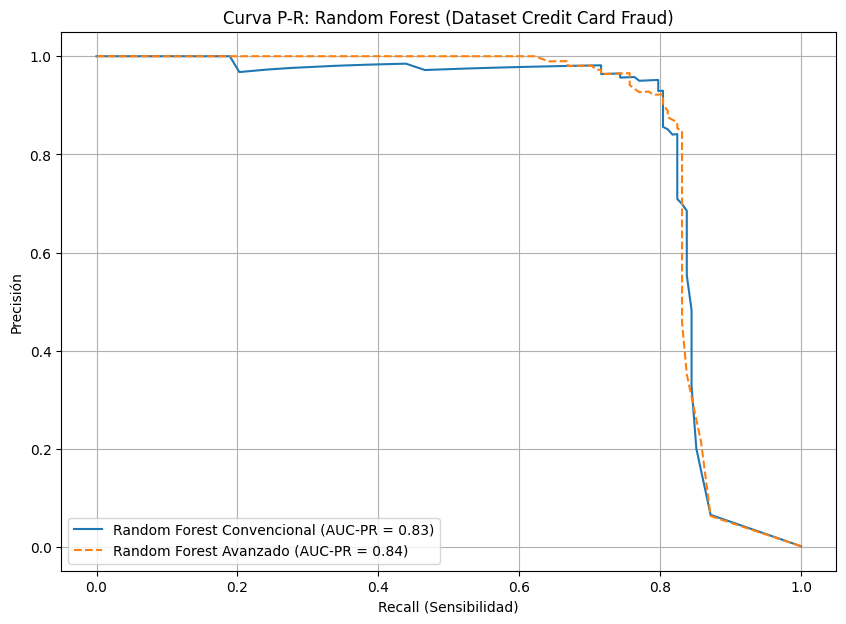

In [20]:
# --- CELDA 13: ANÁLISIS AVANZADO (sample_weight) CON DT, SVC y RF ---

print("📊 --- COMPARATIVA AVANZADA (sample_weight) CON MODELOS COMPLEJOS --- 📊")

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Re-usamos las variables X_train, y_train, X_test, y_test, y sample_weights de la Celda 10

# Definimos los 3 modelos a comparar. 
# NOTA: SVC(probability=True) es VITAL para poder usar .predict_proba() y crear la curva P-R.
models_to_compare = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVC': SVC(random_state=42, probability=True), 
    'Random Forest': RandomForestClassifier(random_state=42)
}

try:
    for model_name, model_base in models_to_compare.items():
        print(f"\n{'='*60}\nProbando modelo: {model_name}\n{'='*60}")

        # --- Modelo Convencional ---
        print(f"Entrenando {model_name} (Convencional)...")
        # Usamos .set_params para asegurar que es una instancia "limpia"
        model_conv = model_base.set_params(random_state=42) 
        model_conv.fit(X_train, y_train)
        y_probs_conv = model_conv.predict_proba(X_test)[:, 1]

        # --- Modelo Avanzado (sample_weight) ---
        print(f"Entrenando {model_name} (Avanzado con sample_weight)...")
        model_adv = model_base.set_params(random_state=42)
        model_adv.fit(X_train, y_train, sample_weight=sample_weights)
        y_probs_adv = model_adv.predict_proba(X_test)[:, 1]
        print("Entrenamiento completado.")

        # --- Evaluación Numérica (Avanzado) ---
        # Mostramos los resultados del modelo avanzado con el umbral por defecto (0.5)
        y_pred_adv = model_adv.predict(X_test)
        print(f"\n--- Resultados del {model_name} Avanzado (Umbral 0.5) ---")
        print("Matriz de Confusión:")
        print(confusion_matrix(y_test, y_pred_adv))
        print("\nReporte de Clasificación:")
        print(classification_report(y_test, y_pred_adv, target_names=['Normal', 'Fraude'], zero_division=0))

        # --- Evaluación Gráfica (Curva P-R) ---
        print(f"\nGenerando Curva P-R comparativa ({model_name})...")
        precision_conv, recall_conv, _ = precision_recall_curve(y_test, y_probs_conv)
        precision_adv, recall_adv, _ = precision_recall_curve(y_test, y_probs_adv)
        auc_pr_conv = auc(recall_conv, precision_conv)
        auc_pr_advanced = auc(recall_adv, precision_adv)

        plt.figure(figsize=(10, 7))
        plt.plot(recall_conv, precision_conv, label=f'{model_name} Convencional (AUC-PR = {auc_pr_conv:.2f})')
        plt.plot(recall_adv, precision_adv, label=f'{model_name} Avanzado (AUC-PR = {auc_pr_advanced:.2f})', linestyle='--')
        plt.title(f'Curva P-R: {model_name} (Dataset Credit Card Fraud)')
        plt.xlabel('Recall (Sensibilidad)')
        plt.ylabel('Precisión')
        plt.legend()
        plt.grid(True)
        plt.show()

except NameError as e:
    print(f"🚨 ERROR: Asegúrate de haber ejecutado la Celda 10 primero. Error: {e}")
except Exception as e:
    print(f"🚨 Error durante el análisis: {e}")